# Time series forecasting of 'total_rainfall' in Singapore

In this notebook, we will attempt to build various Time Series Forecasting models to predict 'total_rainfall' in Singapore

Dataset taken from: 
https://data.gov.sg/dataset/rainfall-monthly-number-of-rain-days

and will be deployed at AMZ EC2 using docker/streamlit.

1. Importing Libraries and Dataset via API

2. Data cleaning and preprocessing

3. Feature Engineering for Exploratory Analysis

4. Some intoduction about Holt Winter's

5. Modelling using Holt Winter's and fbProphe

6. Conclusion

7. [Deployed](https://i.imgur.com/Bax0NK8.png) via streamlit

8. Suggestions for improvement

In [1]:
import json
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Extract data from API ( data.gov.sg API )

In [2]:
# data obtained from data.gov.sg Rainfall - Monthly Number of Rain Days
# https://data.gov.sg/dataset/rainfall-monthly-number-of-rain-days

url = 'https://data.gov.sg/api/action/datastore_search?resource_id=778814b8-1b96-404b-9ac9-68d6c00e637b&limit=1000'

r = requests.get(url)
files = r.json()

In [3]:
ts = pd.DataFrame(files['result']['records'])


In [4]:
ts.head()

_id total_rainfall    month
0    1           53.8  1994-07
1    2           45.1  1994-08
2    3           23.7  1994-09
3    4           84.7  1994-10
4    5          322.2  1994-11

In [5]:
ts.to_csv('data/temp.csv',index=False)

In [6]:
ts.head()

_id total_rainfall    month
0    1           53.8  1994-07
1    2           45.1  1994-08
2    3           23.7  1994-09
3    4           84.7  1994-10
4    5          322.2  1994-11

## Data processing and cleaning

In [7]:
#parse date to 'month' column

In [8]:
ts=pd.read_csv('data/temp.csv',parse_dates=['month'])

In [9]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   _id             770 non-null    int64         
 1   total_rainfall  770 non-null    float64       
 2   month           770 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 18.2 KB


In [10]:
ts.drop('_id',axis=1,inplace=True)

In [11]:
ts=ts.drop_duplicates(subset=['total_rainfall','month']).reset_index()

In [12]:
ts.head()

index  total_rainfall      month
0      0            53.8 1994-07-01
1      1            45.1 1994-08-01
2      2            23.7 1994-09-01
3      3            84.7 1994-10-01
4      4           322.2 1994-11-01

In [13]:
ts.shape

(460, 3)

In [14]:
ts.drop('index',axis=1,inplace=True)

In [15]:
ts = ts.sort_values('month')

In [16]:
ts.head()

total_rainfall      month
25           107.1 1982-01-01
26            27.8 1982-02-01
27           160.8 1982-03-01
28           157.0 1982-04-01
29           102.2 1982-05-01

## Feature engineering

In [17]:
ts.rename(columns={'month': 'year_month'}, inplace=True)
ts['year'] = ts['year_month'].dt.year
ts['month'] = ts['year_month'].dt.month

In [18]:
ts.shape

(460, 4)

In [19]:
ts.set_index('year_month',inplace=True)

In [20]:
ts.round(1)

total_rainfall  year  month
year_month                             
1982-01-01           107.1  1982      1
1982-02-01            27.8  1982      2
1982-03-01           160.8  1982      3
1982-04-01           157.0  1982      4
1982-05-01           102.2  1982      5
...                    ...   ...    ...
2019-12-01           421.5  2019     12
2020-01-01            88.4  2020      1
2020-02-01            65.0  2020      2
2020-03-01           108.8  2020      3
2020-04-01           188.0  2020      4

[460 rows x 3 columns]

In [21]:
ts.head()

total_rainfall  year  month
year_month                             
1982-01-01           107.1  1982      1
1982-02-01            27.8  1982      2
1982-03-01           160.8  1982      3
1982-04-01           157.0  1982      4
1982-05-01           102.2  1982      5

In [22]:
ts.tail()

total_rainfall  year  month
year_month                             
2019-12-01           421.5  2019     12
2020-01-01            88.4  2020      1
2020-02-01            65.0  2020      2
2020-03-01           108.8  2020      3
2020-04-01           188.0  2020      4

## EDA

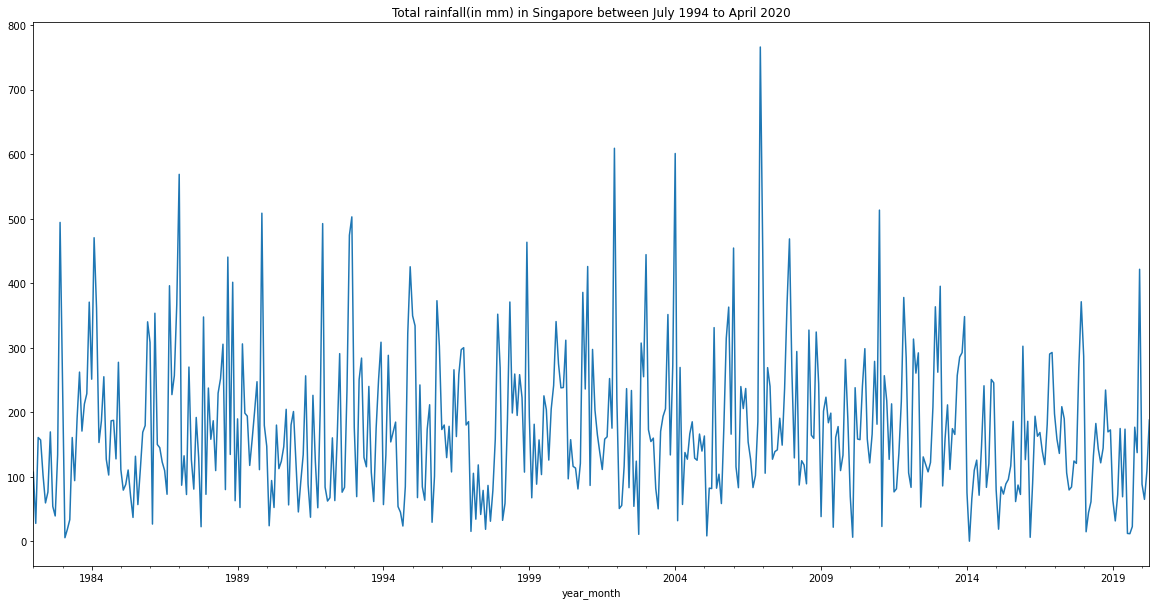

In [23]:
ts['total_rainfall'].plot(figsize=(20,10))
plt.title('Total rainfall(in mm) in Singapore between July 1994 to April 2020');

We re-plot each year separately for ease of viewing.<br>
Generally there are 2 spikes of total rainfall in a year , one around March to May and the other is Nov to Dec.<br>
This is due to Inter-moonsoon Period( meaning before SouthWest Moonson ) and Northeast Monsoon Season respectively.

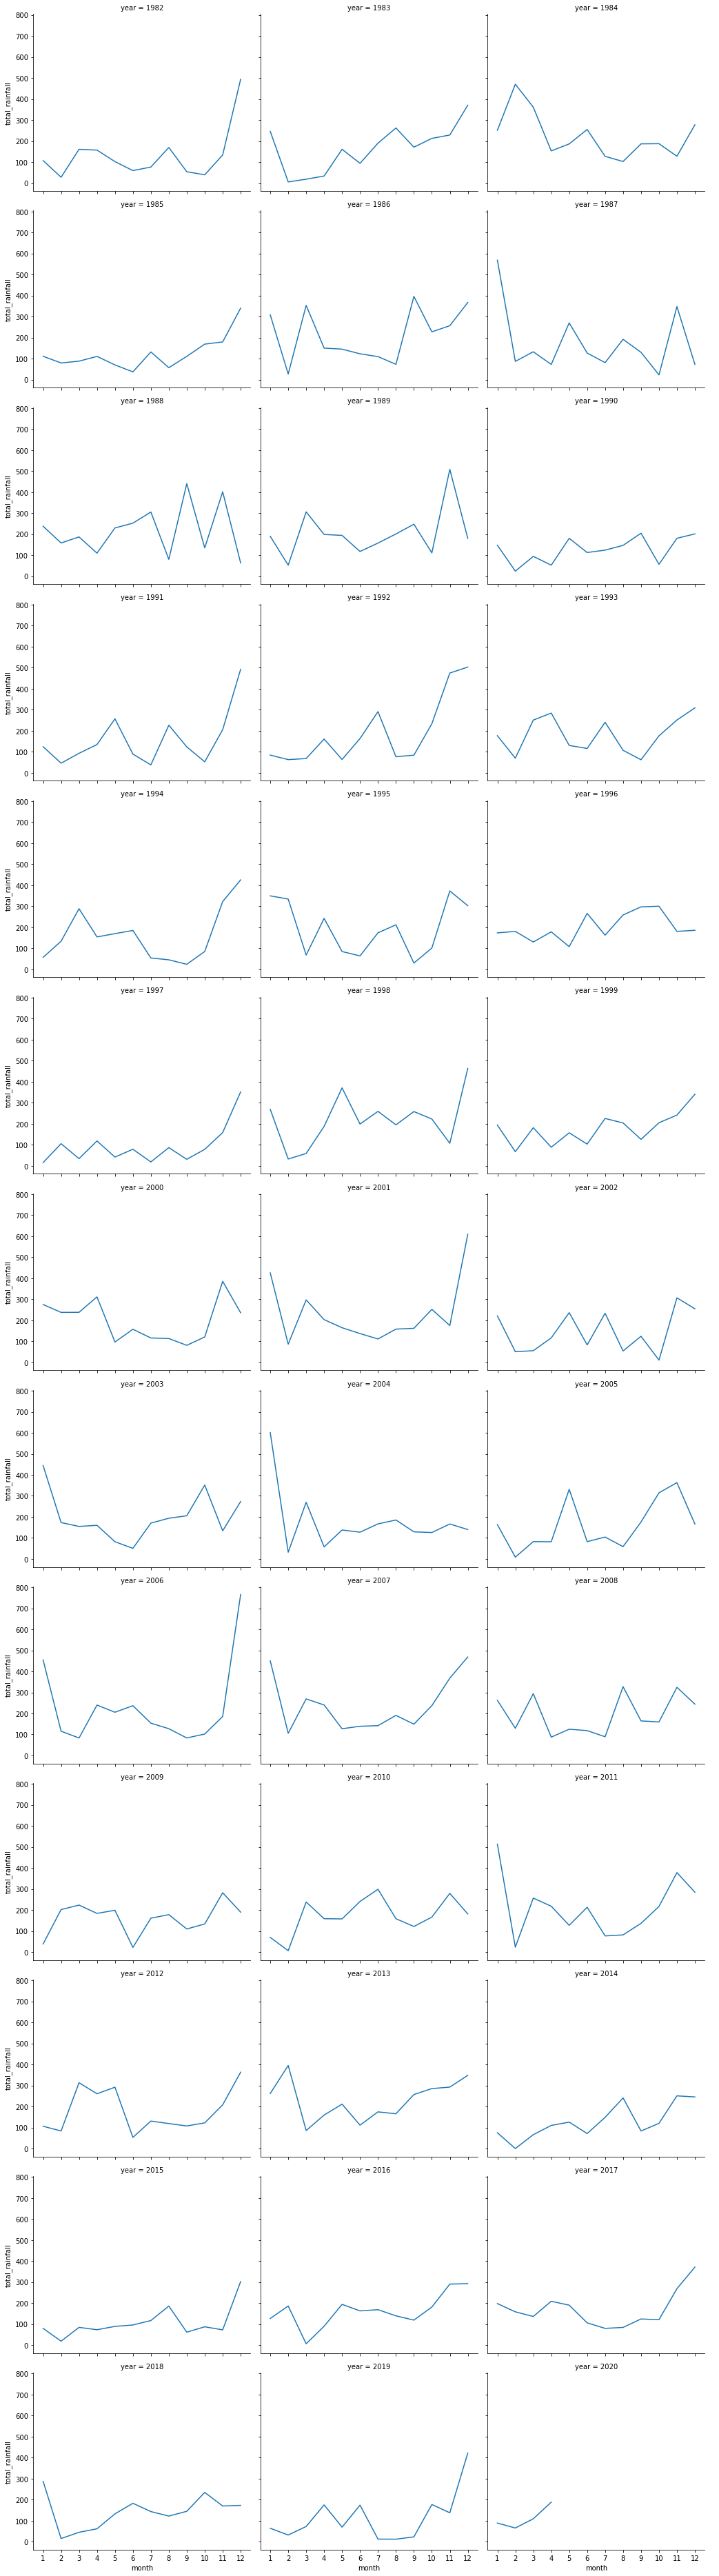

In [24]:
g = sns.FacetGrid(ts,col="year",col_wrap=3,height=4,aspect=1.2)
g.map(sns.lineplot, "month", "total_rainfall")
g.add_legend()
g.set(xticks=list(range(1,13)));

In [25]:
ts_agg =ts.groupby(['year'])['total_rainfall'].agg(['min','max','mean','median','sum','std'])

In [26]:
ts_agg.head()

min    max        mean  median     sum         std
year                                                      
1982   27.8  494.1  131.808333  104.65  1581.7  124.084571
1983    5.6  370.6  166.141667  180.40  1993.7  110.550214
1984  102.7  470.4  223.891667  187.10  2686.7  107.293450
1985   37.0  340.1  123.658333  110.60  1483.9   80.141392
1986   26.7  396.0  211.341667  188.65  2536.1  124.253052

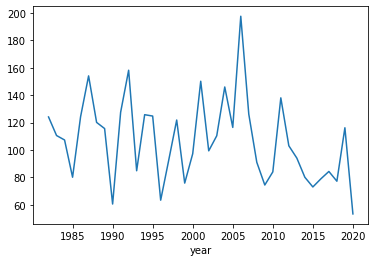

In [27]:
ts_agg['std'].plot();

In [28]:
ts_agg['std']

year
1982    124.084571
1983    110.550214
1984    107.293450
1985     80.141392
1986    124.253052
1987    154.035936
1988    120.126937
1989    115.633129
1990     60.602038
1991    127.487274
1992    158.155384
1993     84.862071
1994    125.748659
1995    124.747198
1996     63.410381
1997     92.451869
1998    121.852470
1999     75.866681
2000     97.274340
2001    150.135649
2002     99.390739
2003    110.367447
2004    145.948318
2005    116.466074
2006    197.528577
2007    126.131006
2008     91.041094
2009     74.470667
2010     84.023223
2011    138.020713
2012    103.077257
2013     94.085757
2014     80.121408
2015     73.046043
2016     78.964735
2017     84.347391
2018     77.237773
2019    116.208273
2020     53.388482
Name: std, dtype: float64

From here we decided to use data from 2013 onwards, so as to obtain a better score due to lower variance.

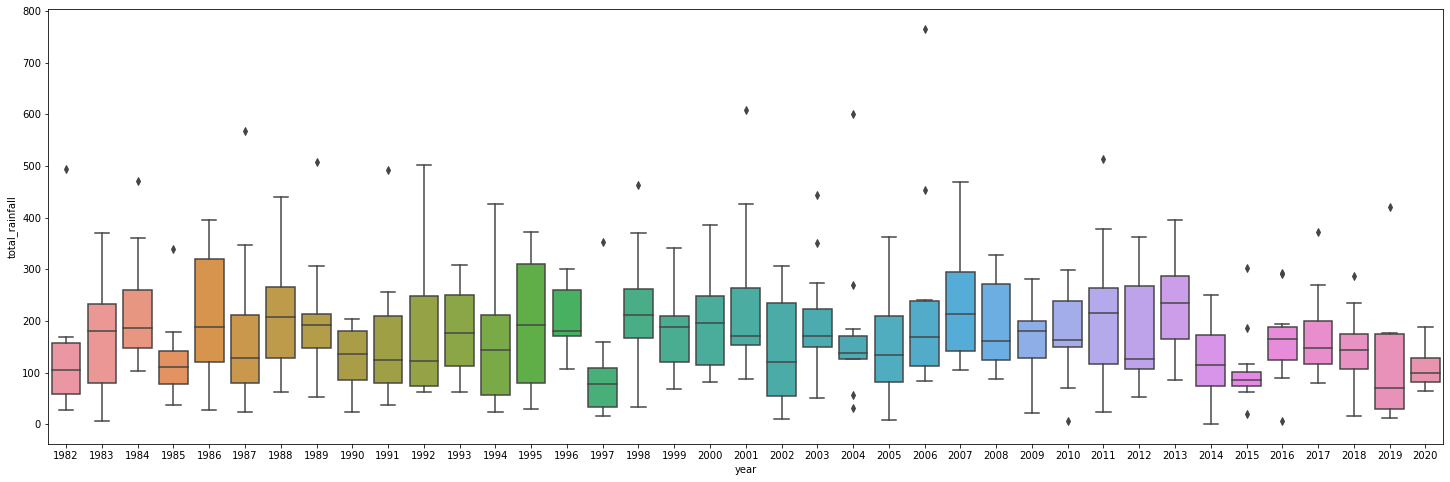

In [29]:
plt.figure(figsize=(25,8))
ax = sns.boxplot(x='year',y='total_rainfall',data=ts,);

In [30]:
ts_agg.to_csv('data/ts_agg.csv')

In [31]:
ts.head()

total_rainfall  year  month
year_month                             
1982-01-01           107.1  1982      1
1982-02-01            27.8  1982      2
1982-03-01           160.8  1982      3
1982-04-01           157.0  1982      4
1982-05-01           102.2  1982      5

In [32]:
rain_min = ts.total_rainfall.min()
rain_max = ts.total_rainfall.max()
rain_mean_min = ts_agg['mean'].min()
rain_mean_max = ts_agg['mean'].max()
rain_mean_std = ts.total_rainfall.max()

Driest month, Min rain during Feb 2014

In [33]:
ts[ts['total_rainfall']== rain_min]

total_rainfall  year  month
year_month                             
2014-02-01             0.2  2014      2

Wettest month, Max rain during Dec 2006

In [34]:
ts[ts['total_rainfall']== rain_max]

total_rainfall  year  month
year_month                             
2006-12-01           765.9  2006     12

The dryiest year occurs during year 1997 ( Average min rain )

In [35]:
ts_agg[ts_agg['mean']==rain_mean_min]

min    max       mean  median     sum        std
year                                                   
1997  15.4  351.9  93.241667   78.65  1118.9  92.451869

The wettest year occurs during year 2007 ( Average max rain )

In [36]:
# Average min rain during year 2007
ts_agg[ts_agg['mean']==rain_mean_max]

min    max        mean  median     sum         std
year                                                      
2007  105.5  468.6  240.516667  213.95  2886.2  126.131006

In [37]:
ts.tail()

total_rainfall  year  month
year_month                             
2019-12-01           421.5  2019     12
2020-01-01            88.4  2020      1
2020-02-01            65.0  2020      2
2020-03-01           108.8  2020      3
2020-04-01           188.0  2020      4

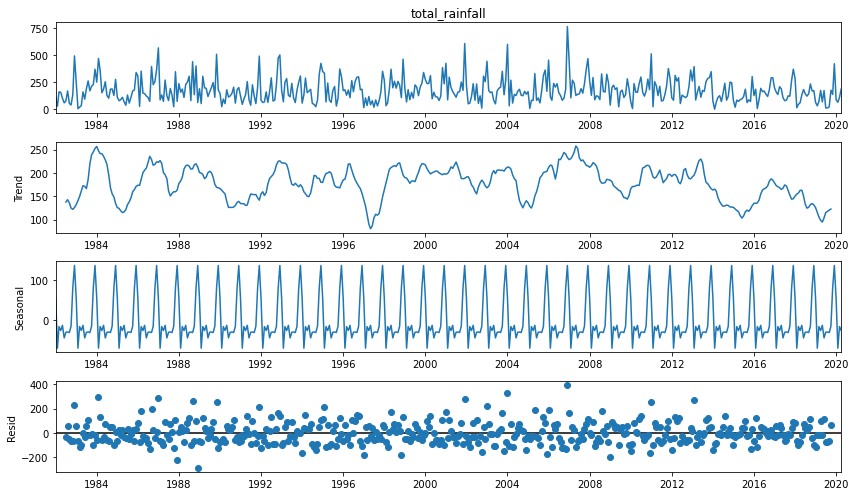

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] =12,7
ts.index.freq = 'MS'
result = seasonal_decompose(ts['total_rainfall'], model='additive') #addictive is chosen based on the chart above ( not multiplicative)
result.plot();

From the Trend chart, we notice there is no obvious trend.Meaning the rain doesn't keep increasing every year, it just oscillates comparing between the years.<br> 
We can see that the lowest is during 1997 which is inline with our previous EDA.<br>
And the trend is like a roller coaster as confirmed by the Residual. If the trend is stable ( no ups or downs ), the residual will be quite flat but we have noticed otherwise here.<br>
Looking at Seasonal, it confirms that there is seasonality as it is cyclical.

## Simple Moving Average - 4 months

In [39]:
ts.head()

total_rainfall  year  month
year_month                             
1982-01-01           107.1  1982      1
1982-02-01            27.8  1982      2
1982-03-01           160.8  1982      3
1982-04-01           157.0  1982      4
1982-05-01           102.2  1982      5

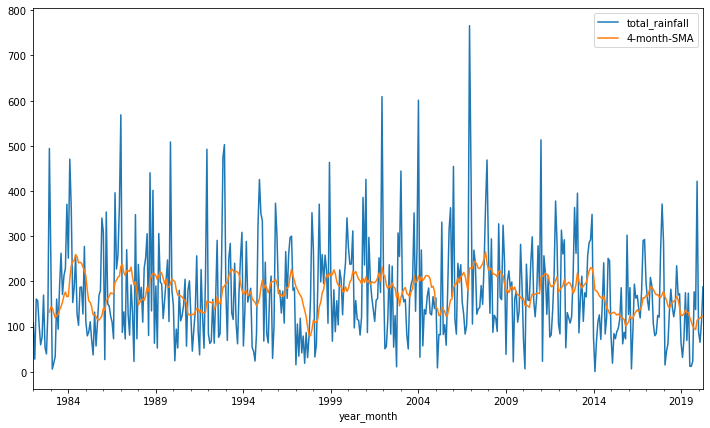

In [40]:
ts['4-month-SMA'] = ts['total_rainfall'].rolling(window=12).mean()
ts[['total_rainfall','4-month-SMA']].plot();

Basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

## Exponentially Weighted Moving Average 

In [41]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 4
alpha = 2/(span+1)

model=SimpleExpSmoothing(ts['total_rainfall']) #fit 
fitted_model=model.fit(smoothing_level=alpha,optimized=False)
ts['SES4']=fitted_model.fittedvalues.shift(-1) # to match pandas version
ts['SES4'].head()

year_month
1982-01-01    107.10000
1982-02-01     75.38000
1982-03-01    109.54800
1982-04-01    128.52880
1982-05-01    117.99728
Freq: MS, Name: SES4, dtype: float64

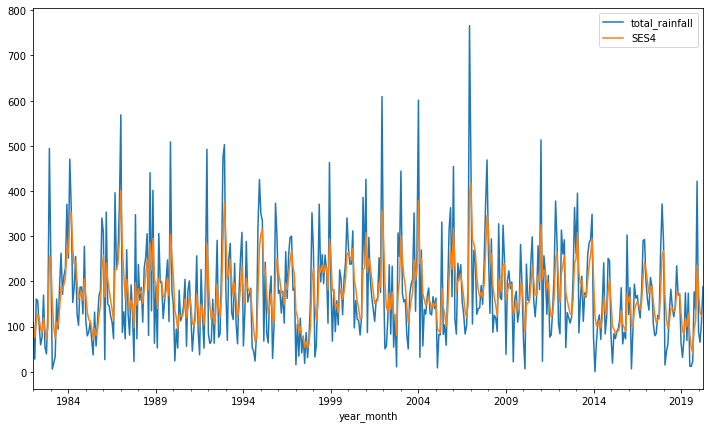

In [42]:
ts[['total_rainfall','SES4']].plot();

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).

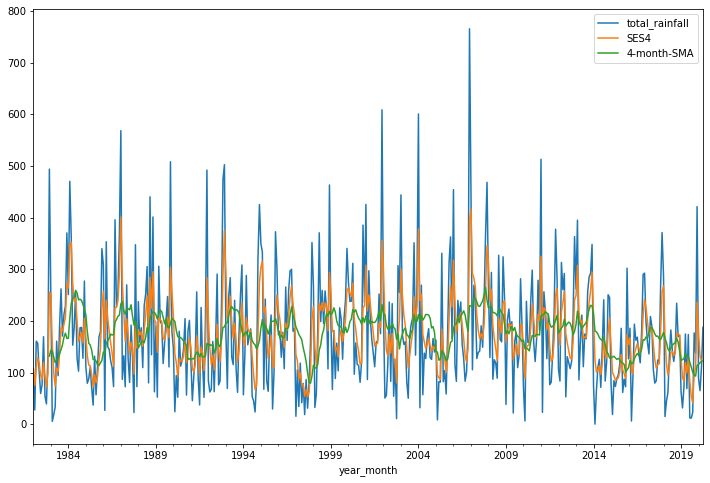

In [43]:
ts[['total_rainfall','SES4','4-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Double Exponential Smoothing

It performs worse than SES because 'total_rainfall' is just oscillating.

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
ts['DESadd12'] = ExponentialSmoothing(ts['total_rainfall'], trend='multiplicative').fit().fittedvalues.shift(-1)

C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\streamprophet37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


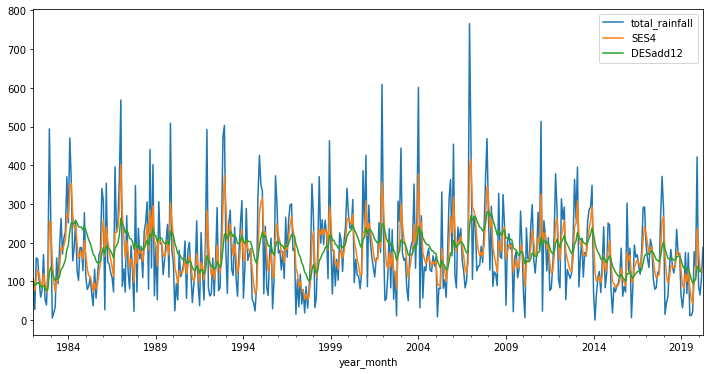

In [45]:
ts[['total_rainfall','SES4','DESadd12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

## Triple Exponential Smoothing ( best performing so far )
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 

In [46]:
ts['TESadd12'] = ExponentialSmoothing(ts['total_rainfall'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\streamprophet37\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\streamprophet37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\streamprophet37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


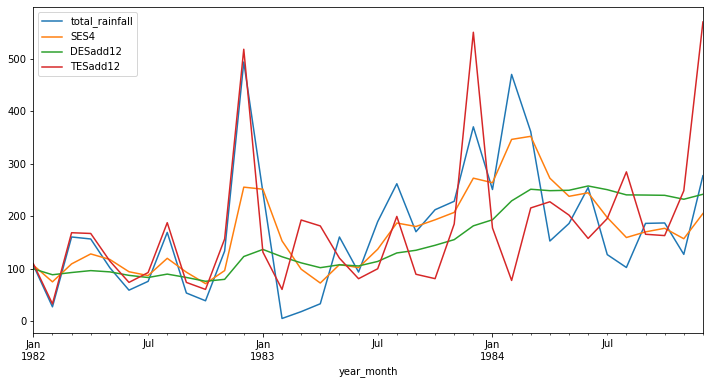

In [47]:
ts[['total_rainfall','SES4','DESadd12','TESadd12']].iloc[:36].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

# Forecasting ( modelling )


## Holt's Winters ( Triple Exponential Smoothing )

In [50]:
ts.shape

(460, 7)

In [51]:
# split train and test ( approx 80%,20% ratio)
# slight difference as we wanted to start from Jan 2012 onwards
# columns affected index, total_rainfall, year, month
train_data = ts.iloc[372:438,0:3] #2013 till 2015
test_data = ts.iloc[438:,0:3] #2016 till 2020

In [52]:
fitted_model = ExponentialSmoothing(train_data['total_rainfall'],seasonal='add',seasonal_periods=12,freq='MS').fit()

C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\streamprophet37\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\streamprophet37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [53]:
# we will just predict until Dec 2020 ( till the test data)
test_predictions = fitted_model.forecast(test_data.shape[0]) 

## plot overall data

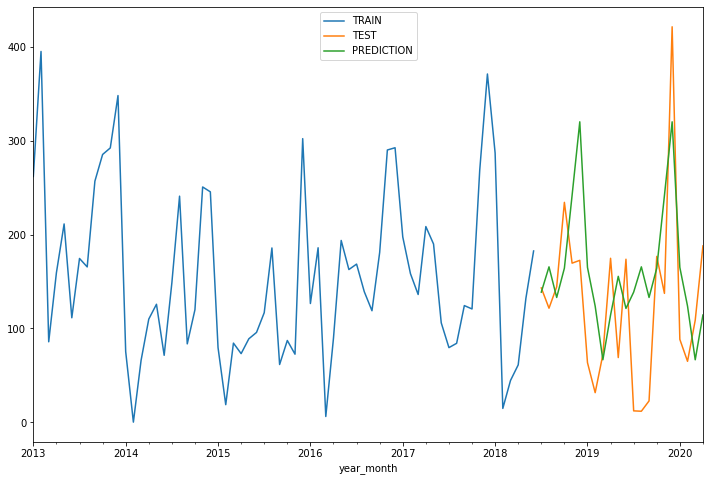

In [54]:
train_data['total_rainfall'].plot(legend=True,label='TRAIN',figsize=(12,8));
test_data['total_rainfall'].plot(legend=True,label='TEST',figsize=(12,8));
test_predictions.plot(legend=True,label='PREDICTION');

## plot the test data ( zoom into year 2013 onwards )

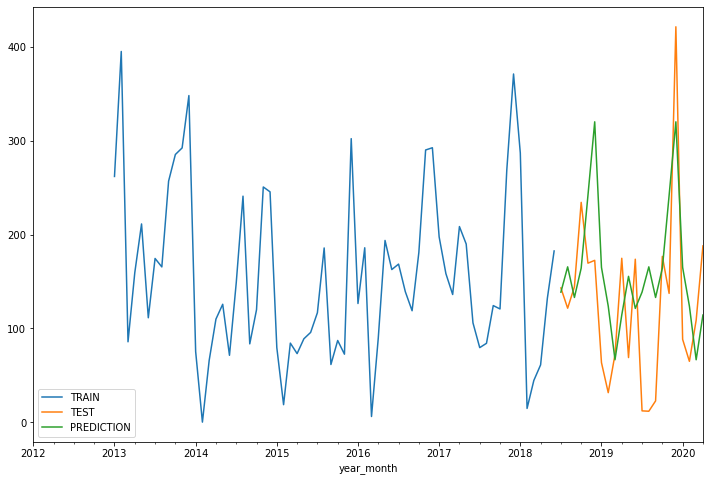

In [55]:
train_data['total_rainfall'].plot(legend=True,label='TRAIN',figsize=(12,8));
test_data['total_rainfall'].plot(legend=True,label='TEST',figsize=(12,8));
test_predictions.plot(legend=True,label='PREDICTION',xlim=['2012-01-01','2020-04-01']);

In [56]:
## Evaluations

from sklearn.metrics import mean_squared_error

In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

naive prediction use, mean of the 'total_rainfall'

In [58]:
ts['total_rainfall'].describe()

count    460.000000
mean     175.938913
std      113.450712
min        0.200000
25%       88.925000
50%      158.400000
75%      237.850000
max      765.900000
Name: total_rainfall, dtype: float64

Since deviation of the the data is 113, it is slight an improvement.<br>
from the zoom-ed chart, it can be observed that the prediction at the valley during mid 2019<br>
and spike during end of 2020 has reduced the RMSE value significantly.

This is limitation of most classic Time series and it depends on the Seasonal, if there is spike/dip<br>
the algorithim will not be able to handle.

In [59]:
## RMSE
np.sqrt(mean_squared_error(np.array(test_data['total_rainfall']),test_predictions.values )).round(1)

84.3

# fbProphet

In [60]:
from fbprophet import Prophet

In [61]:
fb_ts = ts['total_rainfall'].reset_index()

In [62]:
#fbprophet requirement
fb_ts.columns=['ds','y']

In [63]:
fb_ts['ds']= pd.to_datetime(fb_ts['ds'])

In [64]:
fb_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      460 non-null    datetime64[ns]
 1   y       460 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.3 KB


In [65]:
fb_ts.iloc[372:432,0:3].tail()

ds      y
427 2017-08-01   84.2
428 2017-09-01  124.4
429 2017-10-01  120.8
430 2017-11-01  268.6
431 2017-12-01  371.2

In [66]:
train_data = fb_ts.iloc[372:438,0:3] #2013 till 2015
test_data = fb_ts.iloc[438:,0:3] #2018 till end

In [67]:
train_data.tail()

ds      y
433 2018-02-01   14.8
434 2018-03-01   44.6
435 2018-04-01   61.2
436 2018-05-01  132.2
437 2018-06-01  182.6

In [68]:
test_data.head()

ds      y
438 2018-07-01  143.2
439 2018-08-01  121.6
440 2018-09-01  144.4
441 2018-10-01  234.4
442 2018-11-01  169.6

In [69]:
m = Prophet(yearly_seasonality=True,seasonality_mode='multiplicative')
m.fit(train_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
future = m.make_future_dataframe(periods=test_data.shape[0],freq ='MS') # make 22 months prediction , same as test, freq = 'Month Start'

In [71]:
forecast = m.predict(future)

In [72]:
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
83 2019-12-01  122.016308  220.487679  390.444154   121.999043   122.031267   
84 2020-01-01  121.628680   44.899716  206.111792   121.609727   121.644805   
85 2020-02-01  121.241052    5.487098  175.797214   121.220264   121.258686   
86 2020-03-01  120.878432  -71.563591  101.856958   120.855851   120.897525   
87 2020-04-01  120.490804   24.414999  190.598700   120.466696   120.511264   

    multiplicative_terms  multiplicative_terms_lower  \
83              1.513306                    1.513306   
84              0.044185                    0.044185   
85             -0.238970                   -0.238970   
86             -0.921423                   -0.921423   
87             -0.124565                   -0.124565   

    multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
83                    1.513306  1.513306      1.513306      1.513306   
84                    0.044185  0.044185      0.044185      0.044185   
85                   -0.238970 -0.238970     -0.238970     -0.238970   
86                   -0.921423 -0.921423     -0.921423     -0.921423   
87                   -0.124565 -0.124565     -0.124565     -0.124565   

    additive_terms  additive_terms_lower  additive_terms_upper        yhat  
83             0.0                   0.0                   0.0  306.664295  
84             0.0                   0.0                   0.0  127.002814  
85             0.0                   0.0                   0.0   92.268021  
86             0.0                   0.0                   0.0    9.498254  
87             0.0                   0.0                   0.0  105.481827

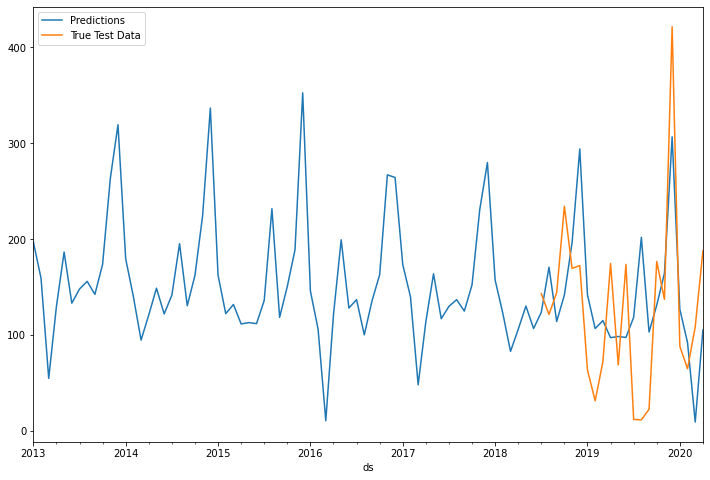

In [73]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test_data.plot(x='ds',y='y',label='True Test Data',legend=True,ax=ax);

In [74]:
test_data['y'].values

array([143.2, 121.6, 144.4, 234.4, 169.6, 172.6,  63.6,  31.6,  72.2,
       174.8,  69. , 173.8,  12.2,  11.8,  22.8, 176.8, 137.4, 421.5,
        88.4,  65. , 108.8, 188. ])

In [75]:
## RMSE
fc = test_data.shape[0]
np.sqrt(mean_squared_error(test_data['y'].values,forecast[-fc:]['yhat'].values)).round(1)

80.6

# Predict the future ( Crystal Ball )

As time series forecasting requires fresh data, we will re-run fbProphet using all data and predict the future

In [76]:
m = Prophet(yearly_seasonality=True,seasonality_mode='multiplicative')
m.fit(fb_ts)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
future = m.make_future_dataframe(periods=8,freq ='MS') # make 8 months prediction , till the end of 2020

In [78]:
forecast = m.predict(future)

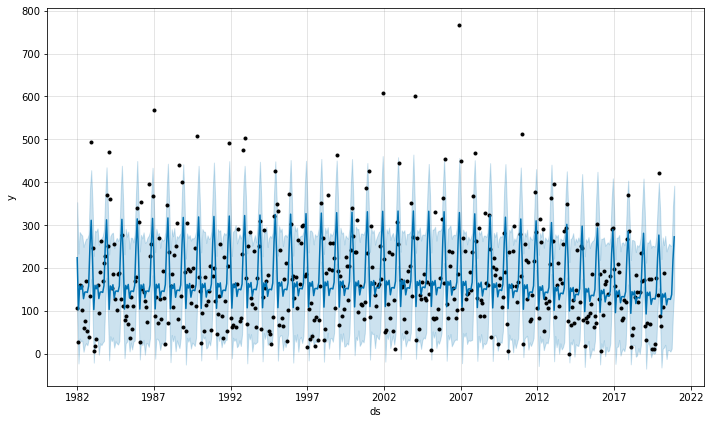

In [79]:
fig1 = m.plot(forecast)

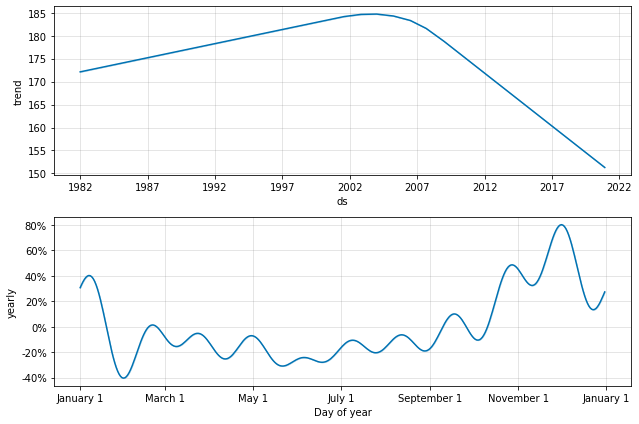

In [80]:
fig2 = m.plot_components(forecast)


In [81]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [82]:
fb_ts.to_csv('data/fb_ts.csv',index=False)

## Conclusion
* We select Fbprophet as the RMSE is 80.6 with respect to Holt Winter's at 84.3
* Also, because the library works well using default parameter
* And presents a lot of intuitive graph

## Suggestions for Improvement
* Will try to to SARIMA, SARIMAX in the future
* SARIMA with the X is because inclusion exogenous variable ( Multivariate )
* Deep Learning LSTM as there is feedback that might improve the prediction
* Deployment to the cloud and also daily streaming data from NEA would make it even more accurate.